In [15]:
import pandas as pd

# 1. Load the three CSV files
daily = pd.read_csv(r"C:\Users\shara\Downloads\data science project\daily_reminder.csv")
health = pd.read_csv(r"C:\Users\shara\Downloads\data science project\health_monitoring.csv")
safety = pd.read_csv(r"C:\Users\shara\Downloads\data science project\safety_monitoring.csv")

# 2. Quick peek at each DataFrame’s first rows and dtypes
print("=== Daily Reminder ===")
print(daily.head(), "\n", daily.dtypes, "\n")

print("=== Health Monitoring ===")
print(health.head(), "\n", health.dtypes, "\n")

print("=== Safety Monitoring ===")
print(safety.head(), "\n", safety.dtypes, "\n")


=== Daily Reminder ===
  Device-ID/User-ID       Timestamp Reminder Type Scheduled Time  \
0             D1000  1/2/2025 11:25      Exercise       13:00:00   
1             D1001   1/3/2025 2:52     Hydration       13:00:00   
2             D1002  1/8/2025 13:50   Appointment       13:30:00   
3             D1003   1/5/2025 5:16      Exercise        8:00:00   
4             D1004   1/1/2025 4:20    Medication       11:30:00   

  Reminder Sent (Yes/No) Acknowledged (Yes/No)  Unnamed: 6  
0                     No                    No         NaN  
1                    Yes                   Yes         NaN  
2                     No                    No         NaN  
3                     No                    No         NaN  
4                     No                    No         NaN   
 Device-ID/User-ID          object
Timestamp                  object
Reminder Type              object
Scheduled Time             object
Reminder Sent (Yes/No)     object
Acknowledged (Yes/No)      obj

In [17]:
# Define a helper to clean column names:
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r"[ %\-\/]", "_", regex=True)   # replace spaces, %, -, / with underscore
        .str.replace(r"[^a-z0-9_]", "", regex=True)  # remove any other special chars
    )
    return df

daily = clean_column_names(daily)
health = clean_column_names(health)
safety = clean_column_names(safety)

# Rename “deviceiduserid” to “user_id” for readability
for df in (daily, health, safety):
    if "deviceiduserid" in df.columns:
        df.rename(columns={"deviceiduserid": "user_id"}, inplace=True)


In [19]:
# Convert each “timestamp” column to pandas datetime (coercing invalid parses to NaT)
for df in (daily, health, safety):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")


In [21]:
# Helper to map “Yes” → 1, “No” → 0 (other values become NaN)
def map_yes_no(s: pd.Series) -> pd.Series:
    return s.map({"Yes": 1, "No": 0})

# List all Yes/No columns in each DataFrame (after cleaning names)
daily_yesno = ["reminder_sent_yesno", "acknowledged_yesno"]
health_yesno = [
    "heart_rate_belowabove_threshold_yesno",
    "blood_pressure_belowabove_threshold_yesno",
    "glucose_levels_belowabove_threshold_yesno",
    "spo2_below_threshold_yesno",
    "alert_triggered_yesno",
    "caregiver_notified_yesno",
]
safety_yesno = ["fall_detected_yesno", "alert_triggered_yesno", "caregiver_notified_yesno"]

for col in daily_yesno:
    if col in daily.columns:
        daily[col] = map_yes_no(daily[col])

for col in health_yesno:
    if col in health.columns:
        health[col] = map_yes_no(health[col])

for col in safety_yesno:
    if col in safety.columns:
        safety[col] = map_yes_no(safety[col])


In [25]:
# (Assuming you have already loaded and cleaned column names as before)

# 1. Drop any "unnamed_*" columns automatically
for df in (daily, health, safety):
    unnamed_cols = [c for c in df.columns if c.startswith("unnamed")]
    df.drop(columns=unnamed_cols, inplace=True)

# 2. Rename "device_id_user_id" to "user_id" if not already done
for df in (daily, health, safety):
    if "device_id_user_id" in df.columns:
        df.rename(columns={"device_id_user_id": "user_id"}, inplace=True)

# 3. Now check missing values again
print("Missing in daily:\n", daily.isna().sum(), "\n")
print("Missing in health:\n", health.isna().sum(), "\n")
print("Missing in safety:\n", safety.isna().sum(), "\n")

# 4. Drop rows missing critical keys: user_id or timestamp
daily.dropna(subset=["user_id", "timestamp"], inplace=True)
health.dropna(subset=["user_id", "timestamp"], inplace=True)
safety.dropna(subset=["user_id", "timestamp"], inplace=True)

# 5. (Optional) If you see missing in other important columns,
#    decide whether to impute or drop—e.g. you might fill missing vitals by forward‐fill.


Missing in daily:
 user_id                 0
timestamp               0
reminder_type           0
scheduled_time          0
reminder_sent_yes_no    0
acknowledged_yes_no     0
dtype: int64 

Missing in health:
 user_id                                        0
timestamp                                      0
heart_rate                                     0
heart_rate_below_above_threshold_yes_no        0
blood_pressure                                 0
blood_pressure_below_above_threshold_yes_no    0
glucose_levels                                 0
glucose_levels_below_above_threshold_yes_no    0
oxygen_saturation_spo_                         0
spo_below_threshold_yes_no                     0
alert_triggered_yes_no                         0
caregiver_notified_yes_no                      0
dtype: int64 

Missing in safety:
 user_id                                  0
timestamp                                0
movement_activity                        0
fall_detected_yes_no                  

In [27]:
# Step 6: Drop exact duplicates in each DataFrame
for df, name in [(daily, "daily"), (health, "health"), (safety, "safety")]:
    before = len(df)
    df.drop_duplicates(inplace=True)
    after = len(df)
    print(f"Dropped {before - after} duplicate rows from {name} sheet.")


Dropped 0 duplicate rows from daily sheet.
Dropped 0 duplicate rows from health sheet.
Dropped 0 duplicate rows from safety sheet.


In [29]:
# Step 7: Sort & reset index

# Sort by user_id, then timestamp
daily.sort_values(["user_id", "timestamp"], inplace=True)
health.sort_values(["user_id", "timestamp"], inplace=True)
safety.sort_values(["user_id", "timestamp"], inplace=True)

# Reset the index to clean up after sorting
daily.reset_index(drop=True, inplace=True)
health.reset_index(drop=True, inplace=True)
safety.reset_index(drop=True, inplace=True)

# Optional: print the first few rows to verify sorting
print(daily.head())
print(health.head())
print(safety.head())


  user_id           timestamp reminder_type scheduled_time  \
0   D1000 2025-01-02 11:25:00      Exercise       13:00:00   
1  D10000 2025-01-21 00:04:00    Medication       16:30:00   
2  D10001 2025-01-22 13:52:00   Appointment       14:30:00   
3  D10002 2025-01-26 11:12:00    Medication       15:30:00   
4  D10003 2025-01-09 15:50:00     Hydration       10:30:00   

  reminder_sent_yes_no acknowledged_yes_no  
0                   No                  No  
1                   No                  No  
2                  Yes                 Yes  
3                  Yes                 Yes  
4                  Yes                 Yes  
  user_id           timestamp  heart_rate  \
0   D1000 2025-01-22 20:42:00         116   
1  D10000 2025-01-24 01:43:00         119   
2  D10001 2025-01-23 14:20:00          76   
3  D10002 2025-01-22 05:01:00          74   
4  D10003 2025-01-01 16:40:00          94   

  heart_rate_below_above_threshold_yes_no blood_pressure  \
0                         

In [33]:
import pandas as pd

# (Assuming your cleaned DataFrames are still in memory as daily, health, safety.
# If not, reload them from the cleaned CSVs.)

# 1a. Show info() for each DataFrame
print("=== Daily Reminder Info ===")
print(daily.info(), "\n")
print("=== Health Monitoring Info ===")
print(health.info(), "\n")
print("=== Safety Monitoring Info ===")
print(safety.info(), "\n")

# 1b. Show descriptive statistics
print("=== Daily Reminder Descriptive Stats ===")
print(daily.describe(include="all"), "\n")

print("=== Health Monitoring Descriptive Stats ===")
print(health.describe(), "\n")

print("=== Safety Monitoring Descriptive Stats ===")
print(safety.describe(include="all"), "\n")


=== Daily Reminder Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               10000 non-null  object        
 1   timestamp             10000 non-null  datetime64[ns]
 2   reminder_type         10000 non-null  object        
 3   scheduled_time        10000 non-null  object        
 4   reminder_sent_yes_no  10000 non-null  object        
 5   acknowledged_yes_no   10000 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 468.9+ KB
None 

=== Health Monitoring Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   user_id                    

In [35]:
# Step 2: Count unique users in each DataFrame
num_daily_users = daily["user_id"].nunique()
num_health_users = health["user_id"].nunique()
num_safety_users = safety["user_id"].nunique()

print(f"Unique users in Daily Reminder: {num_daily_users}")
print(f"Unique users in Health Monitoring: {num_health_users}")
print(f"Unique users in Safety Monitoring: {num_safety_users}")


Unique users in Daily Reminder: 10000
Unique users in Health Monitoring: 10000
Unique users in Safety Monitoring: 10000


In [39]:
# EDA Step 3: Reminder Acknowledgement Rate

# (Assuming 'daily' is already in memory from previous cleaning steps.)
# If not, re-load and clean as before, then run this.

# 1. Calculate the percentage of times reminders were acknowledged vs. not
ack_counts = daily['acknowledged_yes_no'].value_counts(normalize=True) * 100

# 2. Prepare a small summary DataFrame for easy viewing
ack_rate_df = (
    ack_counts
    .rename_axis('acknowledged')      # index name becomes “acknowledged”
    .reset_index(name='percentage')   # bring index into column “acknowledged”
)

print("Reminder Acknowledgement Rate (%):")
print(ack_rate_df)


Reminder Acknowledgement Rate (%):
  acknowledged  percentage
0           No       60.38
1          Yes       39.62


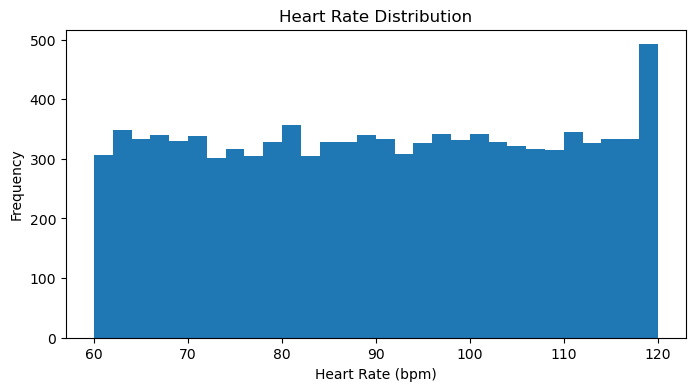

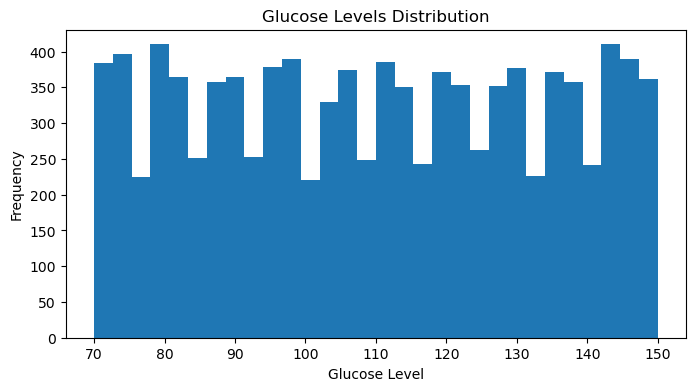

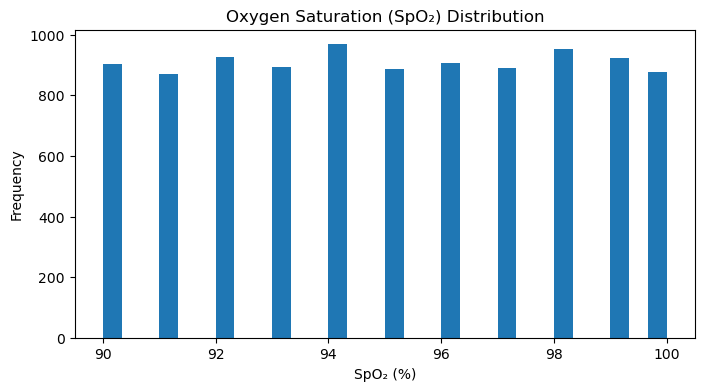

In [43]:
import matplotlib.pyplot as plt

# (Assuming `health` is already in memory from the cleaning phase.)

# 1. Heart Rate distribution
plt.figure(figsize=(8, 4))
plt.hist(health['heart_rate'].dropna(), bins=30)
plt.title('Heart Rate Distribution')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frequency')
plt.show()

# 2. Glucose Levels distribution
plt.figure(figsize=(8, 4))
plt.hist(health['glucose_levels'].dropna(), bins=30)
plt.title('Glucose Levels Distribution')
plt.xlabel('Glucose Level')
plt.ylabel('Frequency')
plt.show()

# 3. Oxygen Saturation (SpO₂) distribution
plt.figure(figsize=(8, 4))
plt.hist(health['oxygen_saturation_spo_'].dropna(), bins=30)
plt.title('Oxygen Saturation (SpO₂) Distribution')
plt.xlabel('SpO₂ (%)')
plt.ylabel('Frequency')
plt.show()


Fall Detection Counts:
fall_detected_yes_no
No     9501
Yes     499
Name: count, dtype: int64


C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1838749601.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [fall_counts.get(0, 0), fall_counts.get(1, 0)],


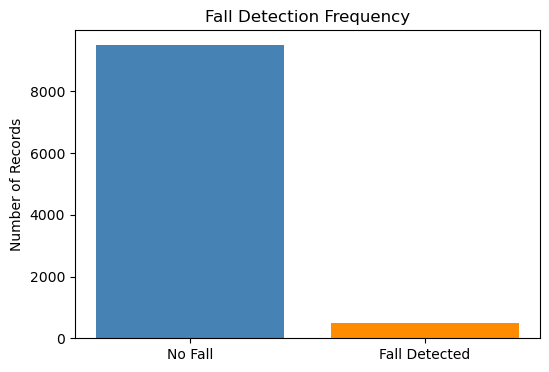

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# (Assuming `safety` is already in memory; otherwise reload the cleaned CSV:
# safety = pd.read_csv(r"C:\Users\shara\Downloads\data science project\safety_monitoring_cleaned.csv")
# )

# 1. Count how many “Yes” vs. “No” in fall_detected_yes_no
fall_counts = safety["fall_detected_yes_no"].value_counts()

print("Fall Detection Counts:")
print(fall_counts)

# 2. Visualize with a bar chart
plt.figure(figsize=(6, 4))
plt.bar(
    ["No Fall", "Fall Detected"],
    [fall_counts.get(0, 0), fall_counts.get(1, 0)],
    color=["steelblue", "darkorange"]
)
plt.title("Fall Detection Frequency")
plt.ylabel("Number of Records")
plt.show()


Reminder Type Counts:
reminder_type
Appointment    2544
Hydration      2525
Medication     2516
Exercise       2415
Name: count, dtype: int64


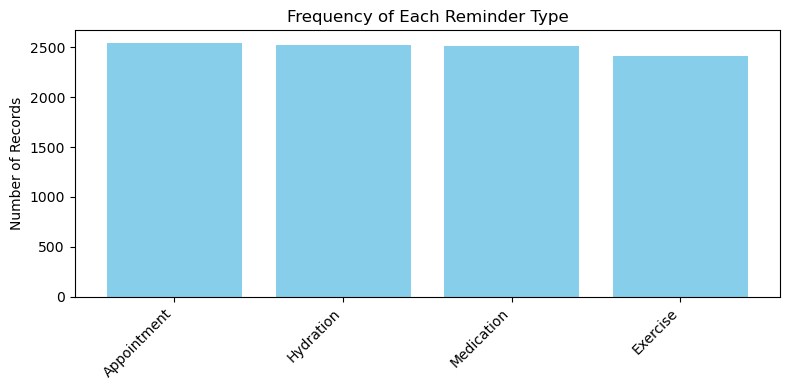

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# (Assume `daily` is in memory; otherwise reload cleaned CSV)
# daily = pd.read_csv(r"C:\Users\shara\Downloads\data science project\daily_reminder_cleaned.csv")

# Count each reminder type
reminder_counts = daily['reminder_type'].value_counts()

print("Reminder Type Counts:")
print(reminder_counts)

# Bar plot of reminder types
plt.figure(figsize=(8, 4))
plt.bar(reminder_counts.index, reminder_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Frequency of Each Reminder Type")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()


Health: Alert Triggered Counts (No=0, Yes=1):
alert_triggered_yes_no
Yes    7367
No     2633
Name: count, dtype: int64

Health: Caregiver Notified Counts (No=0, Yes=1):
caregiver_notified_yes_no
Yes    7367
No     2633
Name: count, dtype: int64


C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1100469388.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [health_alert_counts.get(0, 0), health_alert_counts.get(1, 0)],


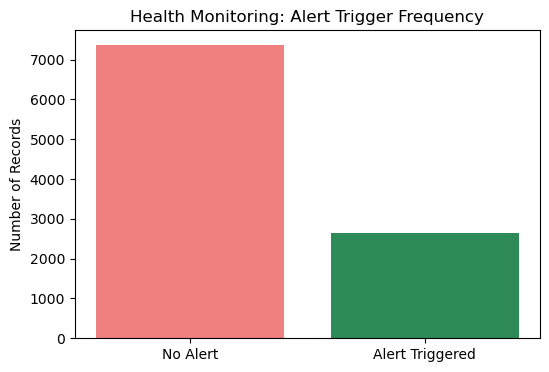

C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1100469388.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [health_caregiver_counts.get(0, 0), health_caregiver_counts.get(1, 0)],


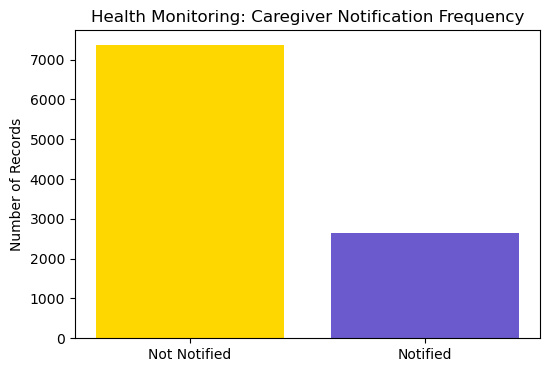

In [49]:
# (Assume `health` is in memory; otherwise reload cleaned CSV)
# health = pd.read_csv(r"C:\Users\shara\Downloads\data science project\health_monitoring_cleaned.csv")

# Count how many times an alert was triggered vs not
health_alert_counts = health['alert_triggered_yes_no'].value_counts()
print("Health: Alert Triggered Counts (No=0, Yes=1):")
print(health_alert_counts)

# Count caregiver notifications
health_caregiver_counts = health['caregiver_notified_yes_no'].value_counts()
print("\nHealth: Caregiver Notified Counts (No=0, Yes=1):")
print(health_caregiver_counts)

# Bar plot for health alerts
plt.figure(figsize=(6, 4))
plt.bar(
    ["No Alert", "Alert Triggered"],
    [health_alert_counts.get(0, 0), health_alert_counts.get(1, 0)],
    color=['lightcoral', 'seagreen']
)
plt.title("Health Monitoring: Alert Trigger Frequency")
plt.ylabel("Number of Records")
plt.show()

# Bar plot for caregiver notifications
plt.figure(figsize=(6, 4))
plt.bar(
    ["Not Notified", "Notified"],
    [health_caregiver_counts.get(0, 0), health_caregiver_counts.get(1, 0)],
    color=['gold', 'slateblue']
)
plt.title("Health Monitoring: Caregiver Notification Frequency")
plt.ylabel("Number of Records")
plt.show()


Safety: Alert Triggered Counts (No=0, Yes=1):
alert_triggered_yes_no
No     9651
Yes     349
Name: count, dtype: int64

Safety: Caregiver Notified Counts (No=0, Yes=1):
caregiver_notified_yes_no
No     9651
Yes     349
Name: count, dtype: int64


C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1391026582.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [safety_alert_counts.get(0, 0), safety_alert_counts.get(1, 0)],


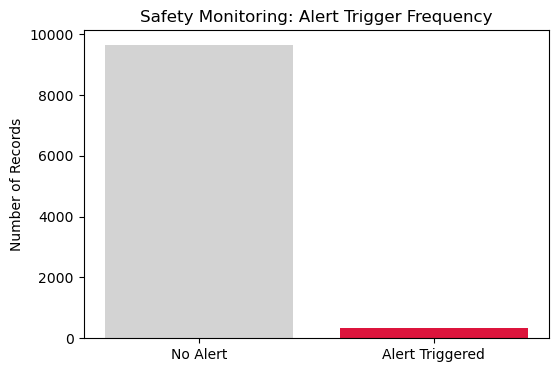

C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1391026582.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [safety_caregiver_counts.get(0, 0), safety_caregiver_counts.get(1, 0)],


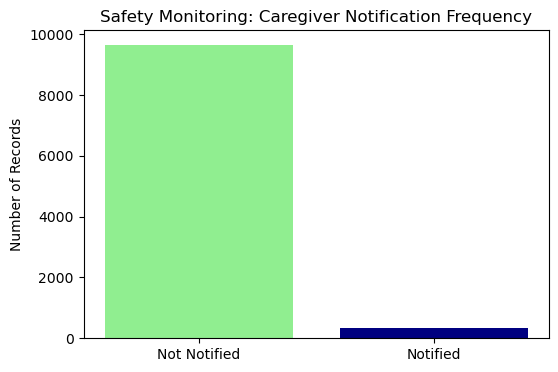

In [51]:
# (Assume `safety` is in memory; otherwise reload cleaned CSV)
# safety = pd.read_csv(r"C:\Users\shara\Downloads\data science project\safety_monitoring_cleaned.csv")

# Count alerts triggered in safety data
safety_alert_counts = safety['alert_triggered_yes_no'].value_counts()
print("Safety: Alert Triggered Counts (No=0, Yes=1):")
print(safety_alert_counts)

# Count caregiver notifications
safety_caregiver_counts = safety['caregiver_notified_yes_no'].value_counts()
print("\nSafety: Caregiver Notified Counts (No=0, Yes=1):")
print(safety_caregiver_counts)

# Bar plot for safety alerts
plt.figure(figsize=(6, 4))
plt.bar(
    ["No Alert", "Alert Triggered"],
    [safety_alert_counts.get(0, 0), safety_alert_counts.get(1, 0)],
    color=['lightgray', 'crimson']
)
plt.title("Safety Monitoring: Alert Trigger Frequency")
plt.ylabel("Number of Records")
plt.show()

# Bar plot for caregiver notifications
plt.figure(figsize=(6, 4))
plt.bar(
    ["Not Notified", "Notified"],
    [safety_caregiver_counts.get(0, 0), safety_caregiver_counts.get(1, 0)],
    color=['lightgreen', 'navy']
)
plt.title("Safety Monitoring: Caregiver Notification Frequency")
plt.ylabel("Number of Records")
plt.show()


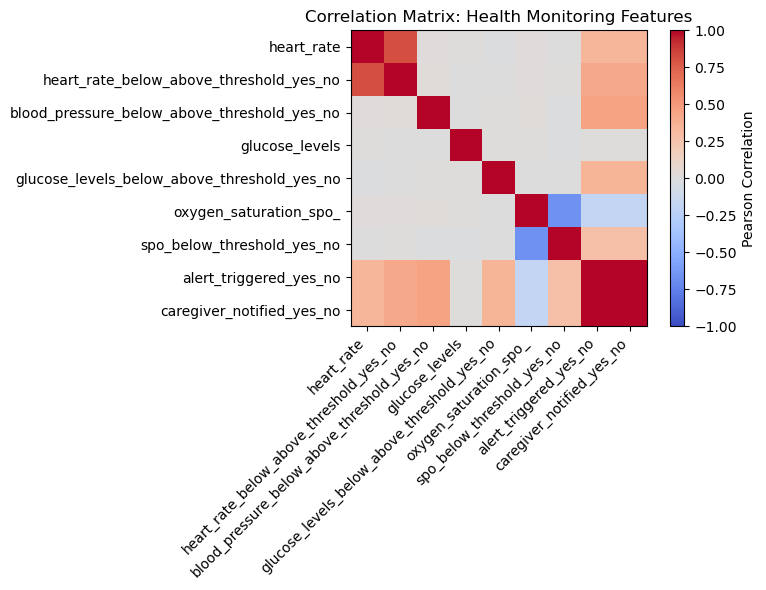


Correlation Matrix (numeric values):
                                             heart_rate  \
heart_rate                                         1.00   
heart_rate_below_above_threshold_yes_no            0.81   
blood_pressure_below_above_threshold_yes_no        0.01   
glucose_levels                                     0.00   
glucose_levels_below_above_threshold_yes_no       -0.01   
oxygen_saturation_spo_                             0.01   
spo_below_threshold_yes_no                        -0.00   
alert_triggered_yes_no                             0.34   
caregiver_notified_yes_no                          0.34   

                                             heart_rate_below_above_threshold_yes_no  \
heart_rate                                                                      0.81   
heart_rate_below_above_threshold_yes_no                                         1.00   
blood_pressure_below_above_threshold_yes_no                                     0.02   
glucose_levels     

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# (Assuming `health` is in memory. If not, reload & clean as before.)

# 1. Identify and map any remaining Yes/No columns to 0/1
yes_no_cols = [
    'heart_rate_below_above_threshold_yes_no',
    'blood_pressure_below_above_threshold_yes_no',
    'glucose_levels_below_above_threshold_yes_no',
    'spo_below_threshold_yes_no',
    'alert_triggered_yes_no',
    'caregiver_notified_yes_no'
]

for col in yes_no_cols:
    if col in health.columns and health[col].dtype == object:
        health[col] = health[col].map({'Yes': 1, 'No': 0})

# 2. Now define numeric_cols again, ensuring they are truly numeric
numeric_cols = [
    'heart_rate',
    'heart_rate_below_above_threshold_yes_no',
    'blood_pressure_below_above_threshold_yes_no',
    'glucose_levels',
    'glucose_levels_below_above_threshold_yes_no',
    'oxygen_saturation_spo_',
    'spo_below_threshold_yes_no',
    'alert_triggered_yes_no',
    'caregiver_notified_yes_no'
]

# Filter only those columns that exist in health and are numeric dtype
numeric_cols = [
    c for c in numeric_cols
    if c in health.columns and pd.api.types.is_numeric_dtype(health[c])
]

# 3. Compute correlation matrix
corr_matrix = health[numeric_cols].corr()

# 4. Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')

plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)

plt.title("Correlation Matrix: Health Monitoring Features")
plt.tight_layout()
plt.show()

# 5. Print numeric values for reference
print("\nCorrelation Matrix (numeric values):")
print(corr_matrix.round(2))
